### import libraries

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib ipympl
from scipy.optimize import curve_fit

### data extraction


In [7]:
# extract data from csv
data = np.genfromtxt("Admission_Predict_Ver1.1.csv", delimiter = ",", skip_header = 1,dtype = float)
data

# Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR ,CGPA,Research,Chance of Admit 
gre = data[:,1]/340
toefl = data[:,2]/120
uni_rating = data[:,3]/5
sop = data[:,4]/5
lor = data[:,5]/5
cg = data[:,6]/10
research = data[:,7]
prob=data[:,-1]

### cgpa seems very important, let us observe how prob varies with cg

/var/folders/p8/1q5ncqdd77j4579t8g3769_40000gn/T/ipykernel_8636/268849990.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


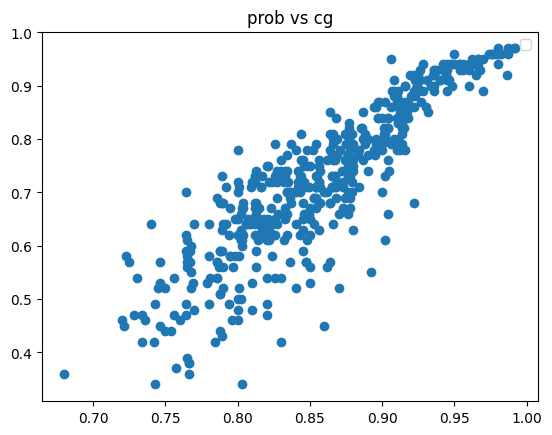

In [8]:
# find probability of getting in as a function of every other variable.
# is it a linear fit?
plt.figure()
plt.scatter(cg,prob)
plt.legend()
plt.title("prob vs cg")
plt.show()

### we use `scipy.optimise` to get a polynomial fit for prob vs cg, and we do get sensible results

the estimated function is y = 0.03694277148947203x^1.585507546884809 + -0.395887201115985


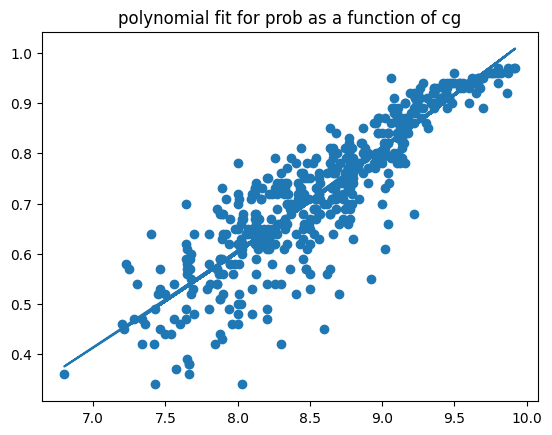

In [9]:
# find relation between cgpa and prob
def func(x,p1,k1,c):
    return k1*(x**p1) + c
(val1,val2,val3),pcov = curve_fit(func,data[:,-3],data[:,-1])
print(f"the estimated function is y = {val2}x^{val1} + {val3}")
y_est = func(data[:,-3],val1,val2,val3)
plt.figure()
plt.scatter(data[:,-3],data[:,-1])
plt.plot(data[:,-3],y_est)
plt.title("polynomial fit for prob as a function of cg")
plt.show()


### prob vs gre and toefl
### to understand this variation, we first normalise the scores, ie., convert them to fractions.

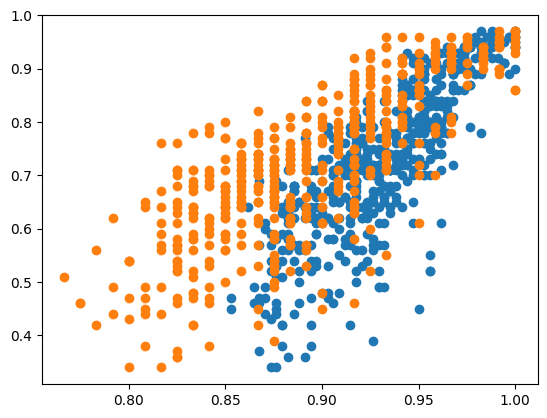

In [10]:
plt.figure()
plt.scatter((gre),prob)
plt.scatter((toefl),prob)
plt.show()

### we continue the same line of reasoning as cgpa with gre an toefl. if the correlation is high, we can incorporate this relation in our final lstsq regression model.

### apparently `curve fit` does not offer a solution(it does not converge to a solution)
### we'll try lstsq

In [11]:
# # assume polynomial fit for prob vs gre
# def func_gre(x,p1,k1,c):
#     return k1*(x**p1) + c
# gre_tuple,pcov = curve_fit(func_gre,gre,prob,maxfev=10000)
# print(f"the estimated function is y = {val2}x^{val1} + {val3}")# gre is a tuple containing 3 values
# y_est = func(gre,*gre_tuple)
# plt.figure()
# plt.scatter(gre,prob)
# plt.plot(gre,y_est)
# plt.show()

In [12]:
gre=gre/340
# Use column_stack to put the vectors side by side
M_gre = np.column_stack([gre**2,np.ones(len(gre))])
# Use the lstsq function to solve for p_1 and p_2
gre_tuple, _, _, _ = np.linalg.lstsq(M_gre, prob, rcond=None) # the output is a tuple
print(f"The estimated equation is {gre_tuple[0]} gre**2 + {gre_tuple[1]}")

The estimated equation is 214079.2051868765 gre**2 + -0.8847615962174196


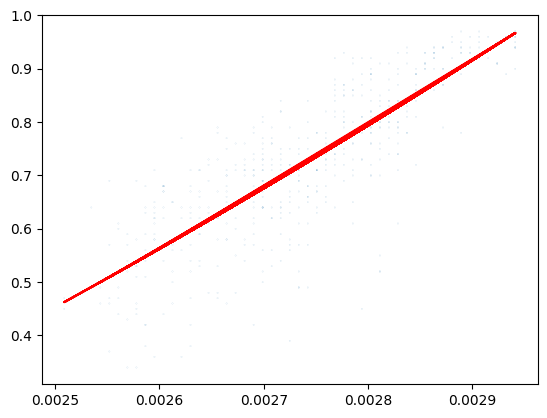

In [13]:
plt.figure()
plt.scatter(gre,prob,gre)
plt.plot(gre,gre_tuple[0]*gre**2+gre_tuple[1], color="red")
plt.show()

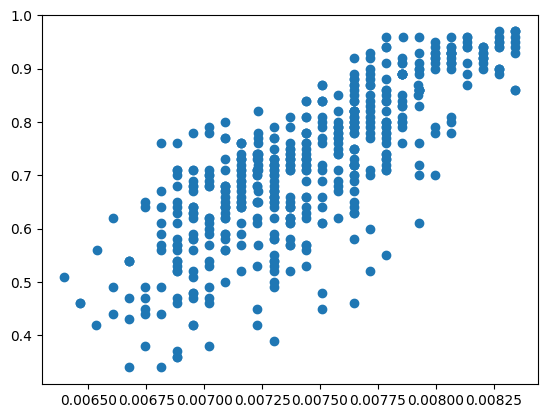

In [14]:
plt.figure()
plt.scatter((gre/340) + (toefl/120),prob)
plt.show()

In [15]:
# def func(gre,toefl,k,p1,p2,c):
#     return k*(gre**p1)*(toefl**p2) + c

# plt.figure()
# x1 = gre/340
# x2 = toefl/120
# plt.scatter(x1*x2,prob)

# (k,p1,p2,c),pcov = curve_fit(func,x1,x2,prob)
# y_est = func(x1,x2,k,p1,p2,c)
# plot()

# # plt.scatter(toefl/120,prob)
# plt.show()

In [16]:
# do least squares regression with all the given variables
# prob = a1 gre + a2 toefl + a3 sop + a4 lor + a5 cg + a6 researchb

### Function to calculate mean square error; we will use this as a coarse metric to measure how good our model is

In [17]:
#calculate mean square error
def mse(x,y):
    mse=0
    for i in range(len(x)):
        error=x[i]-y[i]
        mse=mse+error**2
    return mse/len(x)

## do least squares regression for all the variables(assuming all are independent)

### the matrix is g=Mp,
### M=(gre,toefl,sop,lor,cg,research)
#### notice i do not include university rating as an independent variable(why?)
### p=column vector(a1,a2,a3,a4,a5,a6)

In [18]:
# Use column_stack to put the vectors side by side
M = np.column_stack([gre,toefl,sop,lor,cg,research])
# Use the lstsq function to solve for p_1 and p_2
(a1,a2,a3,a4,a5,a6), _, _, _ = np.linalg.lstsq(M, prob, rcond=None) # the output is a tuple
print(f"The estimated equation is {a1} gre + {a2} toefl + {a3} sop + {a4} lor + {a5} cg + {a6} research")


The estimated equation is -383.6118103888555 gre + 0.44665436970258443 toefl + 0.08252775454840167 sop + 0.09909047062039278 lor + 1.4169362500482707 cg + 0.06054731080743888 research


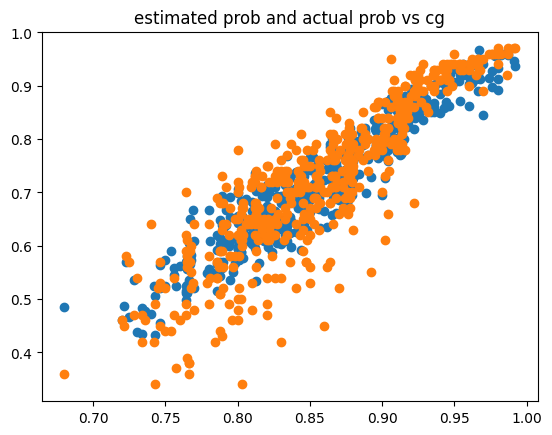

mean square error is 0.00476253191599852


In [19]:
# compare estimated data and real data
def func(gre,toefl,sop,lor,cg,research,a1,a2,a3,a4,a5,a6):
    return a1* gre + a2 *toefl + a3 *sop + a4 *lor + a5 *cg + a6 *research
plt.figure()
plt.scatter(cg, func(gre,toefl,sop,lor,cg,research,a1,a2,a3,a4,a5,a6))
plt.scatter(cg,prob)
plt.title("estimated prob and actual prob vs cg")
plt.show()
print(f"mean square error is {mse(prob,func(gre,toefl,sop,lor,cg,research,a1,a2,a3,a4,a5,a6))}")



### use the fact that prob is proportional to cg^1.5;
### in fact, we do observe that mse reduces 

In [20]:
# Use column_stack to put the vectors side by side
M2 = np.column_stack([gre,toefl,sop,lor,cg**1.585,research])
# Use the lstsq function to solve for p_1 and p_2
(b1,b2,b3,b4,b5,b6), _, _, _ = np.linalg.lstsq(M2, prob, rcond=None) # the output is a tuple
print(f"The estimated equation is {b1} gre + {b2} toefl + {b3} sop + {b4} lor + {b5} cg**1.585 + {b6} research")

The estimated equation is -193.56068653362993 gre + 0.3262198710463333 toefl + 0.04525758511796691 sop + 0.08374711916894911 lor + 1.0773586059377627 cg**1.585 + 0.04525004261586253 research


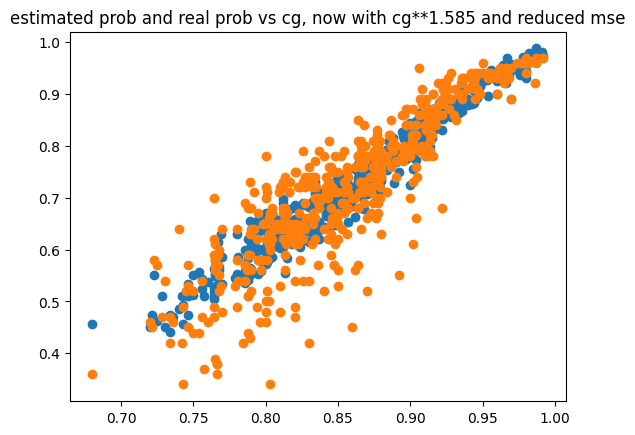

mean square error is 0.004071741188193842


In [21]:
# compare estimated data and real data
def func2(gre,toefl,sop,lor,cg,research,a1,a2,a3,a4,a5,a6):
    return b1* gre + b2 *toefl + b3 *sop + b4 *lor + b5 *cg**1.585 + b6 *research
plt.figure()
plt.scatter(cg, func2(gre,toefl,sop,lor,cg,research,b1,b2,b3,b4,b5,b6))
plt.scatter(cg,prob)
plt.title("estimated prob and real prob vs cg, now with cg**1.585 and reduced mse")
plt.show()
print(f"mean square error is {mse(prob,func2(gre,toefl,sop,lor,cg,research,a1,a2,a3,a4,a5,a6))}")
